# Session 7: Advanced GARCH Models and Extensions

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand long memory in volatility and FIGARCH models
2. Specify and estimate multivariate GARCH models
3. Model volatility spillovers across assets
4. Apply Dynamic Conditional Correlation (DCC) models
5. Use realized volatility measures
6. Implement GARCH-in-mean (GARCH-M) models
7. Apply GARCH models to portfolio optimization
8. Calculate Value at Risk (VaR) using GARCH

### Prerequisites
- Session 6: ARCH/GARCH Models
- Understanding of multivariate statistics
- Knowledge of portfolio theory

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal, StudentsT
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Long Memory in Volatility

### 1.1 Evidence for Long Memory

**Empirical observation**: Autocorrelation in absolute returns decays **very slowly**.

GARCH(1,1) implies **exponential decay**:
$$\rho_k \approx (\alpha + \beta)^k$$

But empirically, decay is **hyperbolic** (power law):
$$\rho_k \sim k^{-d}, \quad 0 < d < 1$$

This is **long memory** or **long-range dependence**.

### 1.2 IGARCH Model

When $\alpha + \beta = 1$, we have **Integrated GARCH**:
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

with $\alpha + \beta = 1$.

**Properties**:
- Shocks persist indefinitely
- No unconditional variance
- Often found in practice
- But theoretically problematic

### 1.3 FIGARCH Model

**Fractionally Integrated GARCH** by Baillie et al. (1996):

Uses fractional differencing operator:
$$(1-L)^d$$

where $0 < d < 1$ controls memory.

**FIGARCH(1,d,1)**:
$$\sigma_t^2 = \omega + \beta \sigma_{t-1}^2 + [1 - \beta L - \phi(L)(1-L)^d]\epsilon_t^2$$

**Interpretation**:
- $d = 0$: Standard GARCH
- $d = 1$: IGARCH
- $0 < d < 1$: Long memory

### 1.4 Testing for Long Memory

**Methods**:
1. **GPH test**: Geweke and Porter-Hudak (1983)
2. **Modified R/S**: Rescaled range statistic
3. **Log periodogram regression**
4. **Wavelet methods**

In [5]:
# Download data for long memory analysis
print("Downloading financial data...")

tickers = ['^GSPC', '^VIX']
data = yf.download(tickers, start='2000-01-01', end='2024-01-01', progress=False)['Close']
data.columns = ['SP500', 'VIX']
data = data.dropna()

# Calculate returns
returns = data['SP500'].pct_change().dropna() * 100
abs_returns = returns.abs()

print(f"\nData period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")

YF.download() has changed argument auto_adjust default to True

Data period: 2000-01-04 to 2023-12-29
Observations: 6036


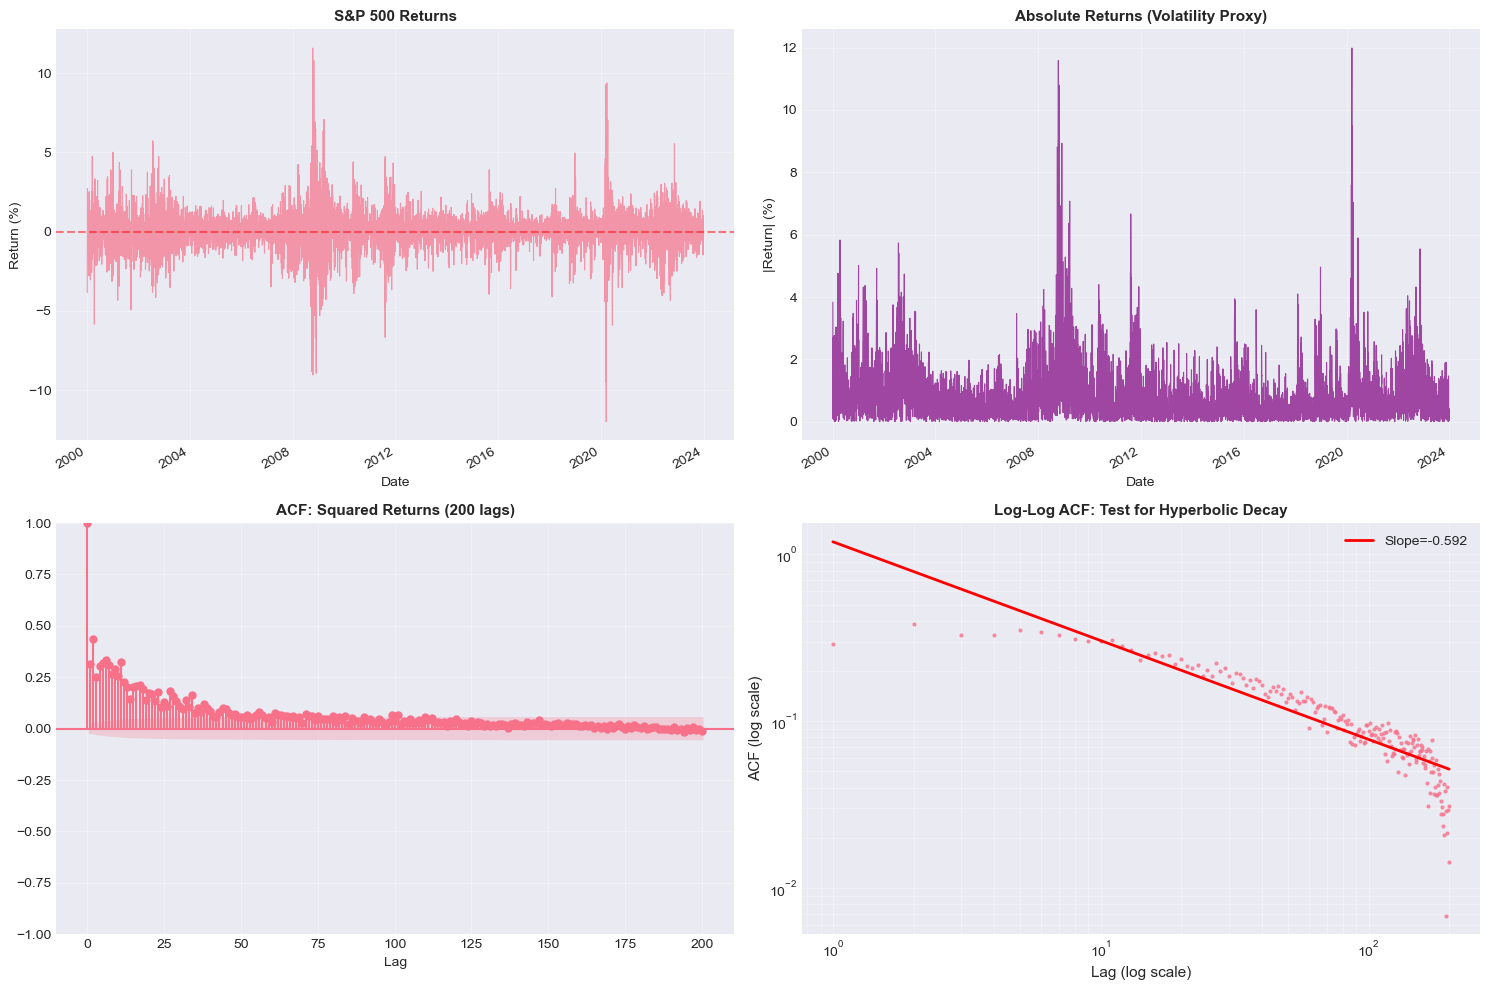


Long Memory Analysis:
• ACF decays very slowly (still significant after 200 lags)
• Log-log plot shows approximate linear relationship
• Negative slope in log-log → hyperbolic decay
• Evidence of long memory in volatility
• Standard GARCH may underestimate persistence


In [8]:
# Analyze long memory
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns
returns.plot(ax=axes[0, 0], linewidth=0.8, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('S&P 500 Returns', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(True, alpha=0.3)

# Absolute returns
abs_returns.plot(ax=axes[0, 1], linewidth=0.8, alpha=0.7, color='purple')
axes[0, 1].set_title('Absolute Returns (Volatility Proxy)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('|Return| (%)')
axes[0, 1].grid(True, alpha=0.3)

# ACF of squared returns (long lags)
plot_acf(returns**2, lags=200, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF: Squared Returns (200 lags)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].grid(True, alpha=0.3)

# Log-log plot of ACF (test for hyperbolic decay)
acf_vals = acf(abs_returns, nlags=200, fft=True)
lags = np.arange(1, 201)
# Remove non-positive ACF values for log-log plot
positive_mask = acf_vals[1:] > 0
axes[1, 1].loglog(lags[positive_mask], acf_vals[1:][positive_mask], 'o', markersize=2, alpha=0.7)
axes[1, 1].set_xlabel('Lag (log scale)', fontsize=11)
axes[1, 1].set_ylabel('ACF (log scale)', fontsize=11)
axes[1, 1].set_title('Log-Log ACF: Test for Hyperbolic Decay', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, which='both')

# Fit line in log-log space
valid_indices = positive_mask & (acf_vals[1:] > 0.01)  # Remove very small values
if np.sum(valid_indices) > 10:
    log_lags = np.log(lags[valid_indices])
    log_acf = np.log(acf_vals[1:][valid_indices])
    slope, intercept = np.polyfit(log_lags, log_acf, 1)
    axes[1, 1].loglog(lags[valid_indices], 
                     np.exp(intercept) * lags[valid_indices]**slope,
                     'r-', linewidth=2, label=f'Slope={slope:.3f}')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nLong Memory Analysis:")
print("• ACF decays very slowly (still significant after 200 lags)")
print("• Log-log plot shows approximate linear relationship")
print("• Negative slope in log-log → hyperbolic decay")
print("• Evidence of long memory in volatility")
print("• Standard GARCH may underestimate persistence")

In [10]:
# Compare GARCH vs IGARCH
print("\n" + "="*60)
print("GARCH vs IGARCH Comparison")
print("="*60)

# Fit GARCH(1,1)
garch = arch_model(returns, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = garch.fit(disp='off')

alpha_garch = garch_fit.params['alpha[1]']
beta_garch = garch_fit.params['beta[1]']
persistence_garch = alpha_garch + beta_garch

print("\nGARCH(1,1):")
print(f"  α: {alpha_garch:.4f}")
print(f"  β: {beta_garch:.4f}")
print(f"  α + β: {persistence_garch:.4f}")
print(f"  AIC: {garch_fit.aic:.2f}")

# Test if α + β = 1
if persistence_garch > 0.99:
    print(f"\n  ⚠ Very close to unit root (α + β ≈ 1)")
    print(f"  → IGARCH may be appropriate")

# Note: arch package doesn't directly support FIGARCH
# Would need specialized implementation
print("\nNote: FIGARCH estimation requires specialized software")
print("(e.g., rugarch in R, or custom implementation)")


GARCH vs IGARCH Comparison

GARCH(1,1):
  α: 0.1212
  β: 0.8628
  α + β: 0.9840
  AIC: 16707.82

Note: FIGARCH estimation requires specialized software
(e.g., rugarch in R, or custom implementation)


## 2. Multivariate GARCH Models

### 2.1 Why Multivariate GARCH?

**Applications**:
- Portfolio optimization
- Risk management
- Volatility spillovers
- Hedging strategies
- Asset pricing

**Need**: Model time-varying covariance matrix $H_t$.

### 2.2 VEC and BEKK Models

**VEC (Vech) Model** - Bollerslev et al. (1988):
$$\text{vech}(H_t) = C + A \cdot \text{vech}(\epsilon_{t-1}\epsilon_{t-1}^\top) + B \cdot \text{vech}(H_{t-1})$$

**Problem**: 
- For N assets: $(N(N+1)/2)^2$ parameters
- Positive definiteness not guaranteed

**BEKK Model** - Engle and Kroner (1995):
$$H_t = C^\top C + A^\top \epsilon_{t-1}\epsilon_{t-1}^\top A + B^\top H_{t-1} B$$

**Advantages**:
- Guarantees positive definite $H_t$
- More parsimonious: $N^2(N+1)/2 + N$ parameters
- Still computationally intensive for large N

### 2.3 Dynamic Conditional Correlation (DCC)

**DCC Model** - Engle (2002):

$$H_t = D_t R_t D_t$$

where:
- $D_t = \text{diag}(\sqrt{h_{11,t}}, \ldots, \sqrt{h_{NN,t}})$ from univariate GARCH
- $R_t$ is conditional correlation matrix

**DCC specification**:
$$Q_t = (1-a-b)\bar{Q} + a \cdot u_{t-1}u_{t-1}^\top + b \cdot Q_{t-1}$$
$$R_t = \text{diag}(Q_t)^{-1/2} Q_t \text{diag}(Q_t)^{-1/2}$$

where $u_t = D_t^{-1}\epsilon_t$ are standardized residuals.

**Advantages**:
- Two-step estimation (univariate GARCH, then correlations)
- Feasible for large N
- Very popular in practice

In [13]:
# Download multiple assets for multivariate analysis
print("Downloading multiple assets...")

tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT']  # US Large, Tech, Small, International, Bonds
portfolio_data = yf.download(tickers, start='2015-01-01', end='2024-01-01', progress=False)['Close']
portfolio_data = portfolio_data.dropna()

# Calculate returns
portfolio_returns = portfolio_data.pct_change().dropna() * 100
portfolio_returns.columns = ['US_Large', 'Tech', 'Small_Cap', 'International', 'Bonds']

print(f"\nAssets: {list(portfolio_returns.columns)}")
print(f"Period: {portfolio_returns.index[0].date()} to {portfolio_returns.index[-1].date()}")
print(f"Observations: {len(portfolio_returns)}")

# Descriptive statistics
print("\nDescriptive Statistics:")
print(portfolio_returns.describe().round(4))


Assets: ['US_Large', 'Tech', 'Small_Cap', 'International', 'Bonds']
Period: 2015-01-05 to 2023-12-29
Observations: 2263

Descriptive Statistics:
        US_Large       Tech  Small_Cap  International      Bonds
count  2263.0000  2263.0000  2263.0000      2263.0000  2263.0000
mean      0.0274     0.0388     0.0740         0.0507     0.0029
std       1.1159     1.4297     1.3989         1.1399     0.9725
min     -10.9902   -13.2669   -11.9788       -10.9424    -6.6683
25%      -0.4782    -0.6786    -0.5120        -0.3792    -0.5774
50%       0.0543     0.0840     0.1148         0.0555     0.0348
75%       0.5880     0.7951     0.7795         0.5941     0.5614
max       8.4731     9.1492     8.4706         9.0603     7.5195


In [15]:
# Estimate univariate GARCH for each asset
print("\n" + "="*60)
print("Step 1: Univariate GARCH Models")
print("="*60)

garch_models = {}
conditional_vols = pd.DataFrame(index=portfolio_returns.index)
standardized_resids = pd.DataFrame(index=portfolio_returns.index)

for col in portfolio_returns.columns:
    print(f"\nFitting GARCH(1,1) for {col}...")
    
    model = arch_model(portfolio_returns[col], vol='GARCH', p=1, q=1, dist='normal')
    fitted = model.fit(disp='off')
    
    garch_models[col] = fitted
    conditional_vols[col] = fitted.conditional_volatility
    standardized_resids[col] = fitted.std_resid
    
    alpha = fitted.params['alpha[1]']
    beta = fitted.params['beta[1]']
    persistence = alpha + beta
    
    print(f"  α: {alpha:.4f}, β: {beta:.4f}, α+β: {persistence:.4f}")

print("\n✓ Univariate GARCH models estimated")


Step 1: Univariate GARCH Models

Fitting GARCH(1,1) for US_Large...
  α: 0.1591, β: 0.8200, α+β: 0.9791

Fitting GARCH(1,1) for Tech...
  α: 0.1040, β: 0.8778, α+β: 0.9818

Fitting GARCH(1,1) for Small_Cap...
  α: 0.1464, β: 0.8303, α+β: 0.9767

Fitting GARCH(1,1) for International...
  α: 0.2011, β: 0.7739, α+β: 0.9750

Fitting GARCH(1,1) for Bonds...
  α: 0.0750, β: 0.9069, α+β: 0.9819

✓ Univariate GARCH models estimated


In [17]:
# Implement simple DCC estimation
print("\n" + "="*60)
print("Step 2: Dynamic Conditional Correlation (DCC)")
print("="*60)

# Calculate unconditional correlation
unconditional_corr = standardized_resids.corr()
print("\nUnconditional Correlation Matrix:")
print(unconditional_corr.round(4))

# Simple DCC estimation (simplified for demonstration)
def estimate_dcc_simple(std_resids, a=0.05, b=0.90):
    """
    Simplified DCC estimation with fixed parameters.
    For full estimation, use specialized packages.
    """
    T = len(std_resids)
    N = std_resids.shape[1]
    
    # Initialize
    Q_bar = std_resids.cov().values
    Q = np.zeros((T, N, N))
    R = np.zeros((T, N, N))
    Q[0] = Q_bar
    
    # Iterate
    for t in range(1, T):
        u = std_resids.iloc[t-1].values.reshape(-1, 1)
        Q[t] = (1 - a - b) * Q_bar + a * (u @ u.T) + b * Q[t-1]
        
        # Standardize to get correlation
        D_inv = np.diag(1.0 / np.sqrt(np.diag(Q[t])))
        R[t] = D_inv @ Q[t] @ D_inv
    
    return R

# Estimate DCC
print("\nEstimating DCC with a=0.05, b=0.90...")
R_t = estimate_dcc_simple(standardized_resids)

# Extract time-varying correlations
dynamic_corr = pd.DataFrame(index=portfolio_returns.index)
asset_pairs = [
    ('US_Large', 'Tech', 0, 1),
    ('US_Large', 'Bonds', 0, 4),
    ('Tech', 'Bonds', 1, 4)
]

for name1, name2, i, j in asset_pairs:
    dynamic_corr[f'{name1}-{name2}'] = [R_t[t, i, j] for t in range(len(R_t))]

print("\n✓ DCC correlations estimated")


Step 2: Dynamic Conditional Correlation (DCC)

Unconditional Correlation Matrix:
               US_Large    Tech  Small_Cap  International   Bonds
US_Large         1.0000  0.7364     0.7164         0.8221 -0.1886
Tech             0.7364  1.0000     0.7267         0.8429 -0.2267
Small_Cap        0.7164  0.7267     1.0000         0.9063 -0.1212
International    0.8221  0.8429     0.9063         1.0000 -0.1982
Bonds           -0.1886 -0.2267    -0.1212        -0.1982  1.0000

Estimating DCC with a=0.05, b=0.90...

✓ DCC correlations estimated


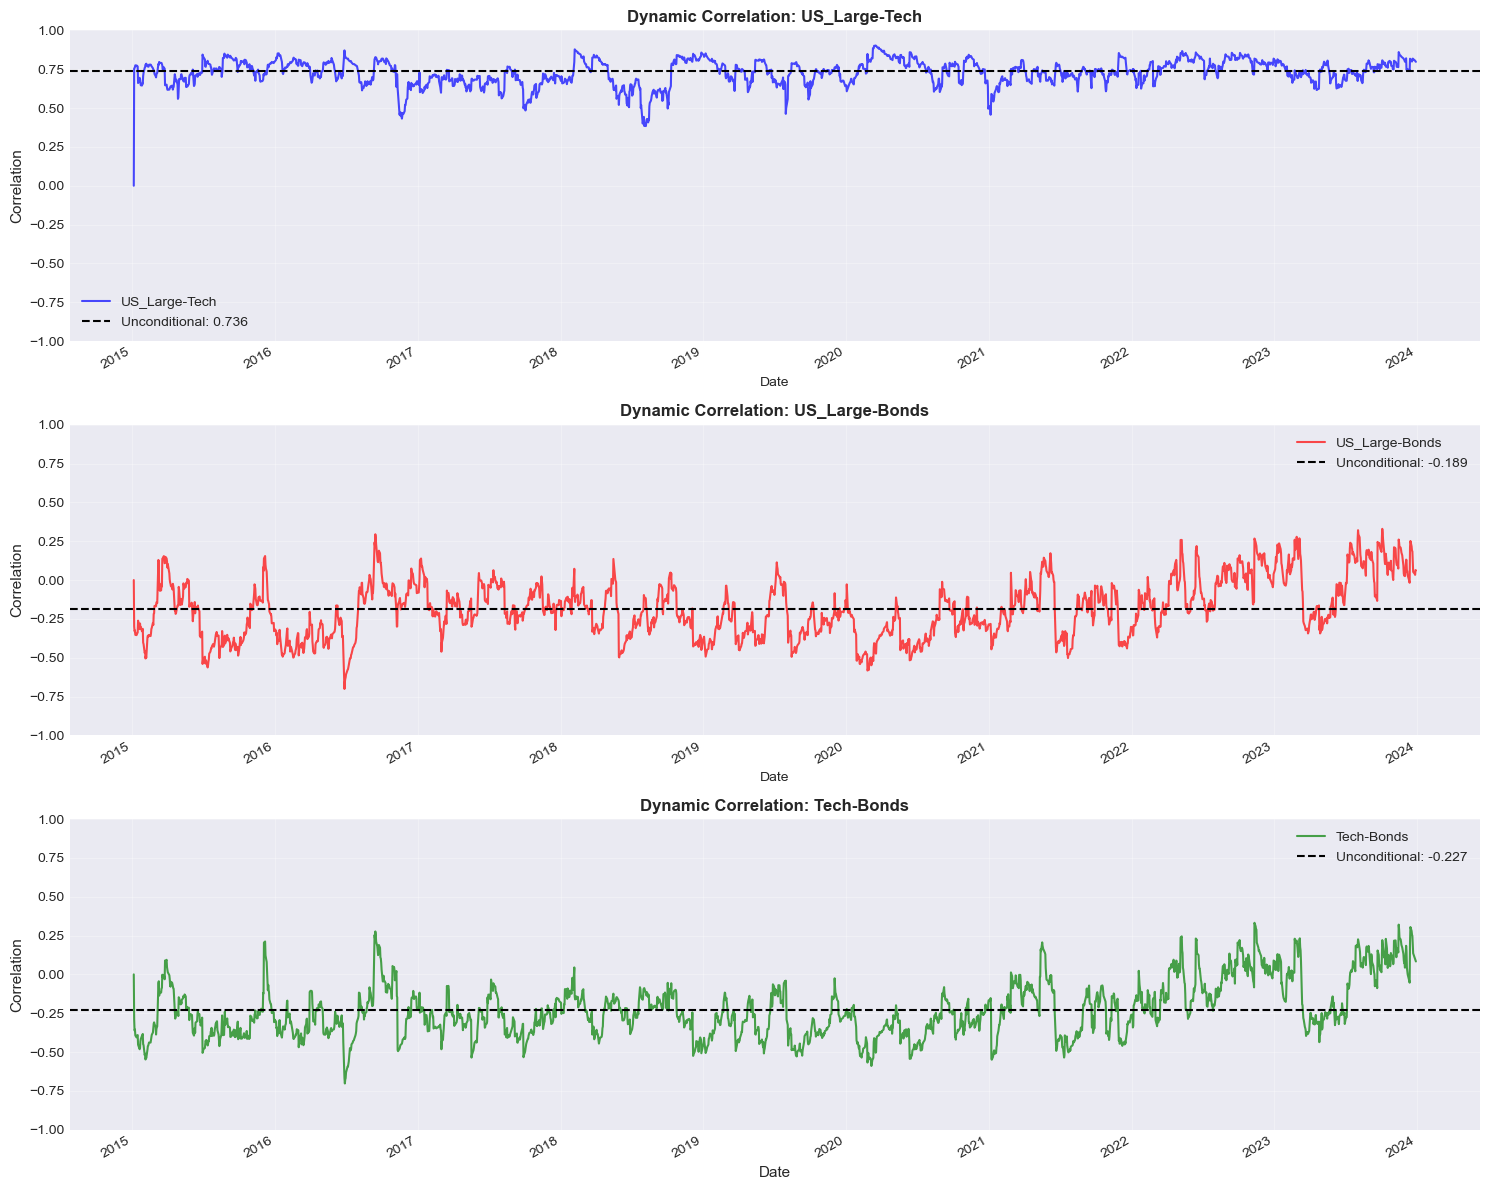


Key Observations:
• Correlations vary substantially over time
• Correlations spike during crisis periods (flight to quality)
• Stock-bond correlation often negative (diversification)
• DCC captures time-varying co-movements


In [19]:
# Visualize dynamic correlations
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

colors = ['blue', 'red', 'green']
for idx, (col, color) in enumerate(zip(dynamic_corr.columns, colors)):
    dynamic_corr[col].plot(ax=axes[idx], linewidth=1.5, color=color, alpha=0.7)
    
    # Add unconditional correlation line
    name1, name2 = col.split('-')
    uncond_corr = unconditional_corr.loc[name1, name2]
    axes[idx].axhline(y=uncond_corr, color='black', linestyle='--', 
                     label=f'Unconditional: {uncond_corr:.3f}')
    
    axes[idx].set_title(f'Dynamic Correlation: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Correlation', fontsize=11)
    axes[idx].set_ylim(-1, 1)
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    if idx == 2:
        axes[idx].set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Correlations vary substantially over time")
print("• Correlations spike during crisis periods (flight to quality)")
print("• Stock-bond correlation often negative (diversification)")
print("• DCC captures time-varying co-movements")

## 3. Volatility Spillovers

### 3.1 Concept of Spillovers

**Volatility spillover**: Volatility in one market affects volatility in another.

**Types**:
1. **Cross-market**: US → Europe → Asia
2. **Cross-asset**: Stocks → Bonds, FX → Commodities
3. **Sector spillovers**: Tech → Financials

### 3.2 Testing for Spillovers

**Multivariate GARCH approach**:
$$h_{ij,t} = f(\epsilon_{i,t-1}, \epsilon_{j,t-1}, h_{ij,t-1})$$

Test if $\epsilon_{j,t-1}$ affects $h_{ii,t}$.

**Granger causality in variance**:
- Does $\epsilon_j^2$ Granger-cause $\epsilon_i^2$?

### 3.3 Diebold-Yilmaz Spillover Index

Based on variance decomposition from VAR:
$$\text{Spillover} = \frac{\sum_{i\neq j} \theta_{ij}}{\sum_{i,j} \theta_{ij}} \times 100\%$$

where $\theta_{ij}$ is variance of variable $i$ explained by shocks to $j$.


Volatility Spillover Analysis


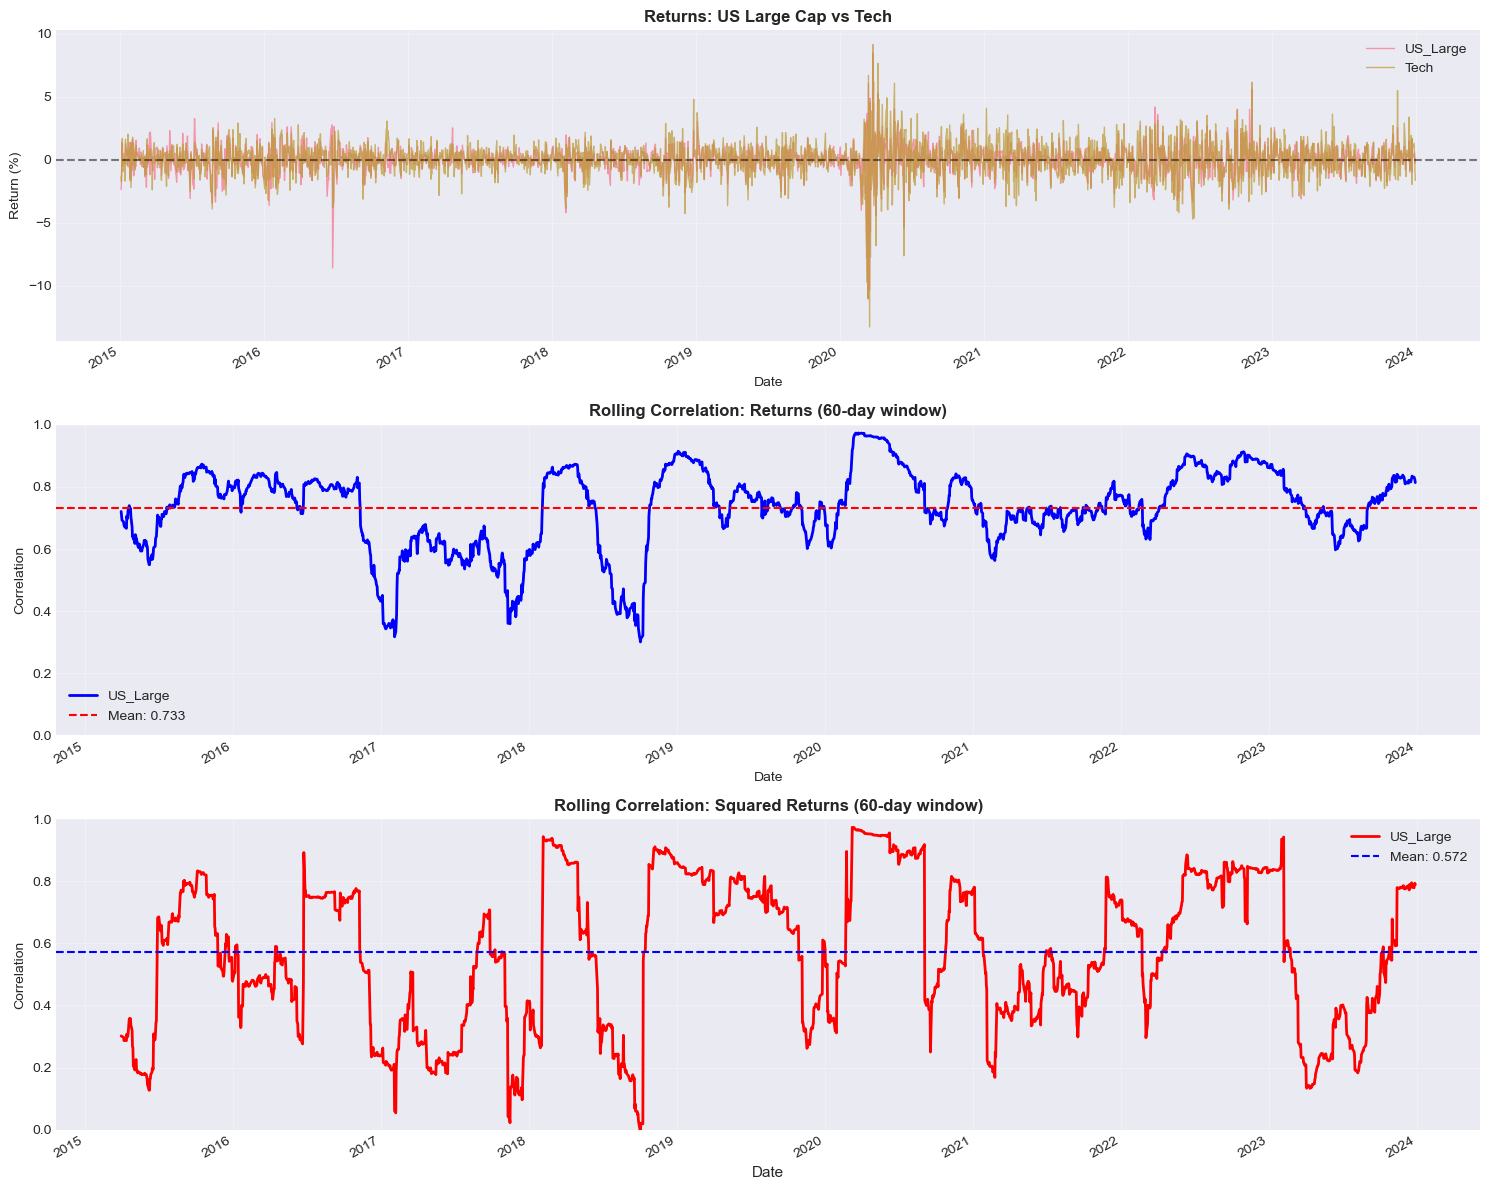


Spillover Insights:
• Average correlation in returns: 0.733
• Average correlation in volatility: 0.572
• Volatility correlation often higher than return correlation
• Spillovers increase during crisis periods


In [22]:
# Analyze volatility spillovers
print("\n" + "="*60)
print("Volatility Spillover Analysis")
print("="*60)

# Calculate rolling correlations of squared returns
window = 60  # 60-day rolling window
squared_returns = portfolio_returns ** 2

# Focus on two assets: US_Large and Tech
rolling_corr = squared_returns[['US_Large', 'Tech']].rolling(window=window).corr()
rolling_corr_series = rolling_corr['US_Large'].xs('Tech', level=1)

# Also calculate rolling correlation of returns
rolling_corr_returns = portfolio_returns[['US_Large', 'Tech']].rolling(window=window).corr()
rolling_corr_returns_series = rolling_corr_returns['US_Large'].xs('Tech', level=1)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Returns
portfolio_returns[['US_Large', 'Tech']].plot(ax=axes[0], linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_title('Returns: US Large Cap vs Tech', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Rolling correlation of returns
rolling_corr_returns_series.plot(ax=axes[1], linewidth=2, color='blue')
axes[1].axhline(y=rolling_corr_returns_series.mean(), color='red', linestyle='--',
               label=f'Mean: {rolling_corr_returns_series.mean():.3f}')
axes[1].set_title(f'Rolling Correlation: Returns ({window}-day window)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Correlation')
axes[1].set_ylim(0, 1)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Rolling correlation of squared returns
rolling_corr_series.plot(ax=axes[2], linewidth=2, color='red')
axes[2].axhline(y=rolling_corr_series.mean(), color='blue', linestyle='--',
               label=f'Mean: {rolling_corr_series.mean():.3f}')
axes[2].set_title(f'Rolling Correlation: Squared Returns ({window}-day window)', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Correlation')
axes[2].set_ylim(0, 1)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSpillover Insights:")
print(f"• Average correlation in returns: {rolling_corr_returns_series.mean():.3f}")
print(f"• Average correlation in volatility: {rolling_corr_series.mean():.3f}")
print("• Volatility correlation often higher than return correlation")
print("• Spillovers increase during crisis periods")

## 4. Realized Volatility

### 4.1 Concept

**Realized Volatility (RV)**: Sum of squared intraday returns.

For day $t$ with $M$ intraday observations:
$$RV_t = \sum_{i=1}^M r_{t,i}^2$$

where $r_{t,i}$ is the $i$-th intraday return on day $t$.

### 4.2 Advantages

- **Direct measure** of actual volatility
- Uses high-frequency data
- More accurate than model-based estimates
- Consistent estimator of integrated variance

### 4.3 HAR-RV Model

**Heterogeneous Autoregressive** model for realized volatility:

$$RV_t = c + \beta_d RV_{t-1} + \beta_w RV_{t-1}^{(w)} + \beta_m RV_{t-1}^{(m)} + \epsilon_t$$

where:
- $RV_{t-1}^{(w)} = \frac{1}{5}\sum_{i=1}^5 RV_{t-i}$ (weekly)
- $RV_{t-1}^{(m)} = \frac{1}{22}\sum_{i=1}^{22} RV_{t-i}$ (monthly)

Captures different volatility horizons.

### 4.4 Evaluating GARCH Forecasts

Use realized volatility as "ground truth":
$$\text{MSE} = \frac{1}{T}\sum_{t=1}^T (RV_t - \hat{\sigma}_t^2)^2$$


GARCH vs VIX (Implied Volatility)

Correlation between GARCH and VIX: 0.8929


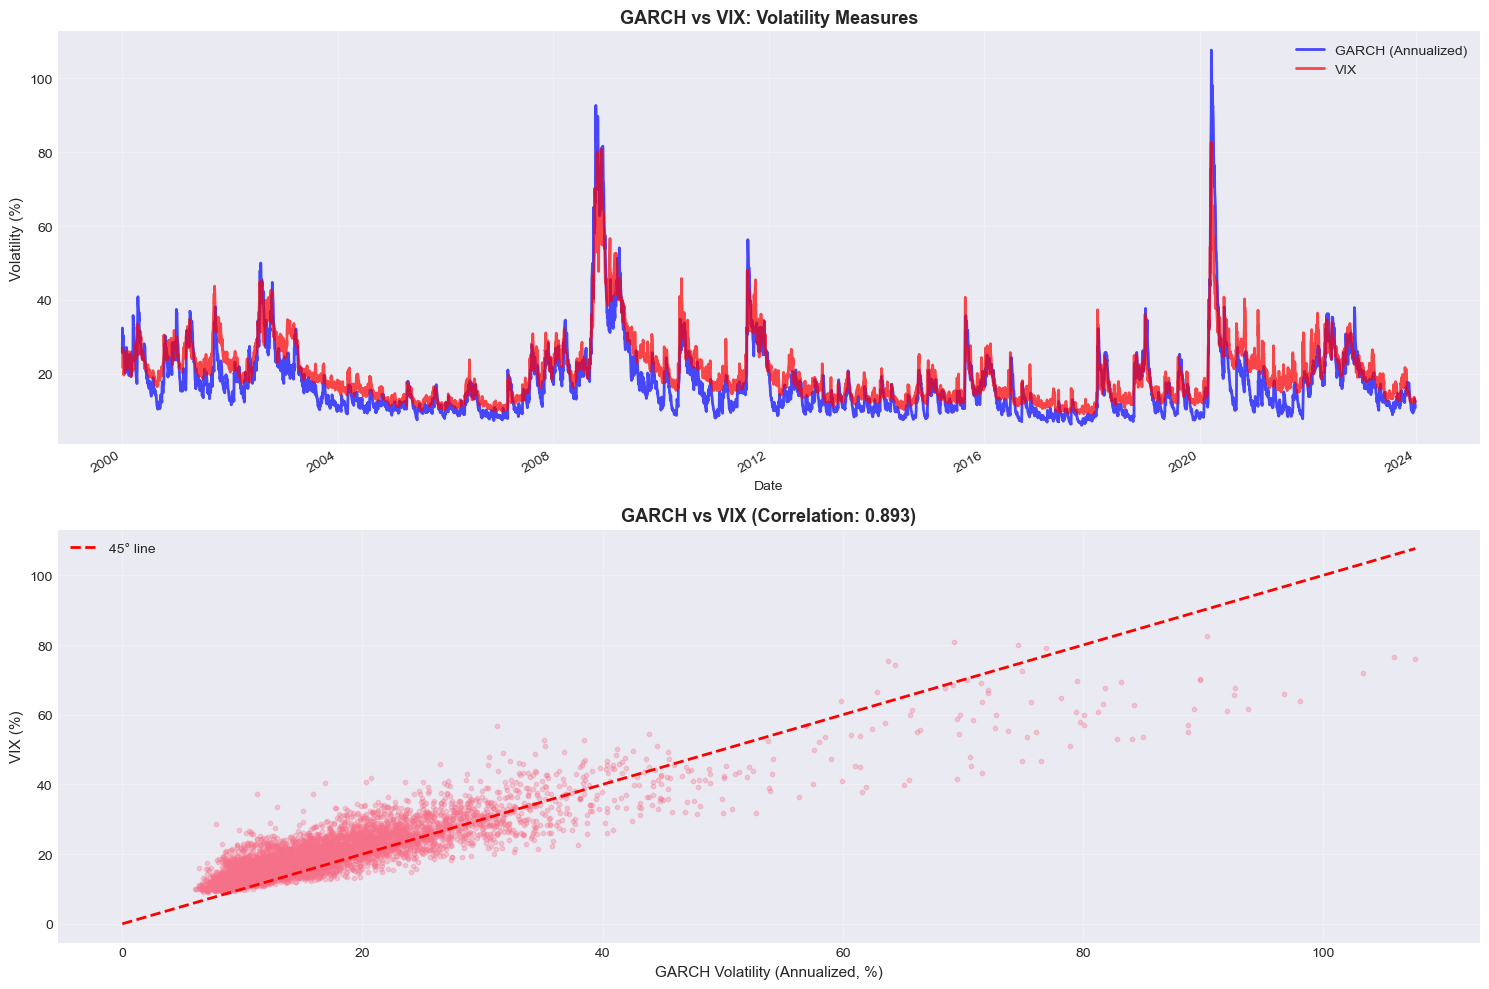


Insights:
• GARCH and VIX are highly correlated
• VIX tends to spike higher during crises (forward-looking)
• GARCH is backward-looking (based on past data)
• Both capture overall volatility regime


In [24]:
# Compare GARCH volatility with VIX (implied volatility proxy)
print("\n" + "="*60)
print("GARCH vs VIX (Implied Volatility)")
print("="*60)

# Fit GARCH to S&P 500
sp_returns = returns[-len(data['VIX']):]
vix = data['VIX'][-len(sp_returns):]

garch_sp = arch_model(sp_returns, vol='GARCH', p=1, q=1, dist='t')
garch_sp_fit = garch_sp.fit(disp='off')
garch_vol = garch_sp_fit.conditional_volatility

# Annualize GARCH volatility (daily to annual)
garch_vol_annual = garch_vol * np.sqrt(252)

# Align dates
common_dates = garch_vol_annual.index.intersection(vix.index)
garch_aligned = garch_vol_annual[common_dates]
vix_aligned = vix[common_dates]

# Calculate correlation
corr = garch_aligned.corr(vix_aligned)

print(f"\nCorrelation between GARCH and VIX: {corr:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series
garch_aligned.plot(ax=axes[0], linewidth=2, label='GARCH (Annualized)', color='blue', alpha=0.7)
vix_aligned.plot(ax=axes[0], linewidth=2, label='VIX', color='red', alpha=0.7)
axes[0].set_title('GARCH vs VIX: Volatility Measures', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Volatility (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(garch_aligned, vix_aligned, alpha=0.3, s=10)
axes[1].plot([0, garch_aligned.max()], [0, garch_aligned.max()], 
            'r--', linewidth=2, label='45° line')
axes[1].set_xlabel('GARCH Volatility (Annualized, %)', fontsize=11)
axes[1].set_ylabel('VIX (%)', fontsize=11)
axes[1].set_title(f'GARCH vs VIX (Correlation: {corr:.3f})', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsights:")
print("• GARCH and VIX are highly correlated")
print("• VIX tends to spike higher during crises (forward-looking)")
print("• GARCH is backward-looking (based on past data)")
print("• Both capture overall volatility regime")

## 5. GARCH-in-Mean (GARCH-M)

### 5.1 Risk-Return Trade-off

**Asset pricing theory**: Expected return depends on risk.

**GARCH-M Model** (Engle, Lilien, Robins, 1987):

**Mean equation**:
$$r_t = \mu + \lambda \sigma_t^2 + \epsilon_t$$

**Variance equation**:
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### 5.2 Interpretation

- $\lambda > 0$: Risk-averse investors require higher return for higher risk
- $\lambda$ measures risk premium per unit of variance
- Tests intertemporal CAPM predictions

### 5.3 Variants

Can also use:
- Volatility: $\mu + \lambda \sigma_t$
- Log-variance: $\mu + \lambda \log(\sigma_t^2)$


GARCH-in-Mean Model Concept

Simple Risk-Return Regression:
  r_t = 0.0209 + 0.0045 × σ²_{t-1}

  Risk premium (λ): 0.0045
  P-value: 0.3779
  R²: 0.0001

  ✗ Risk premium not significant
  → Short-term returns hard to predict


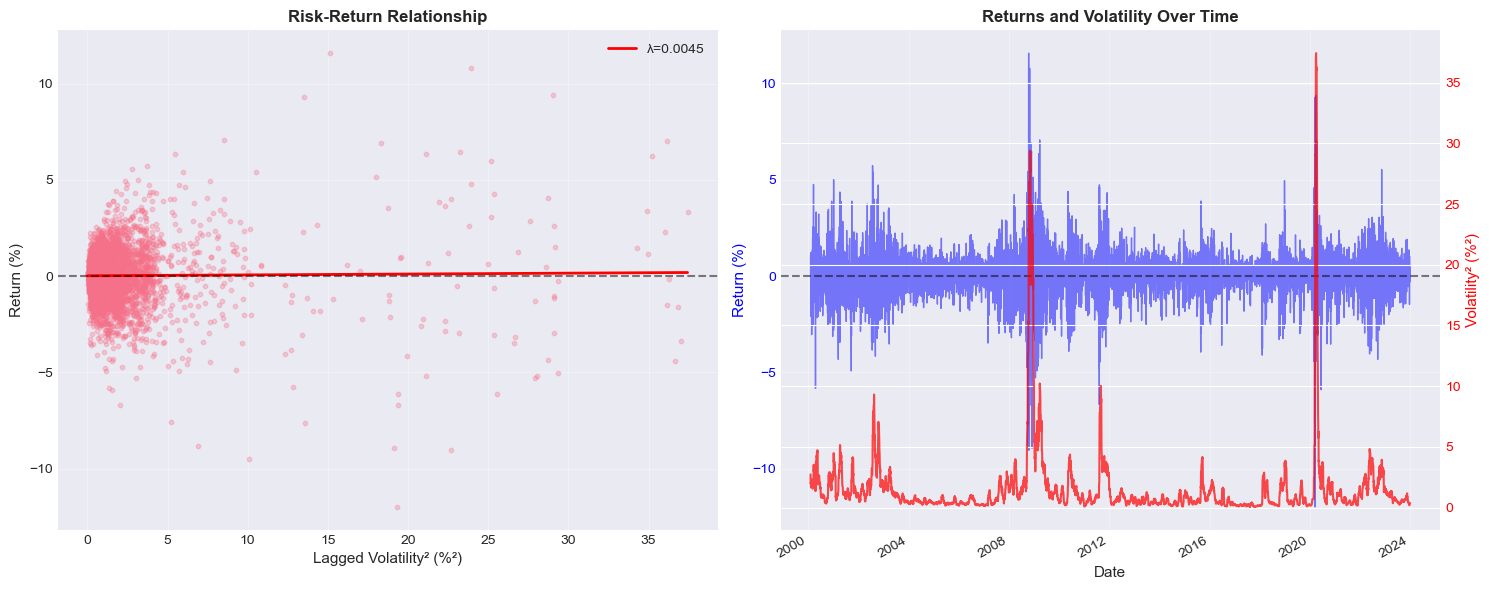


GARCH-M Insights:
• Tests if risk (volatility) predicts returns
• Weak evidence in daily data (market efficiency)
• Stronger at longer horizons
• Important for asset pricing tests


In [27]:
# Note: arch package supports GARCH-M via mean parameter
# This is a simplified demonstration

print("\n" + "="*60)
print("GARCH-in-Mean Model Concept")
print("="*60)

# Calculate realized risk premium
# Use rolling volatility as risk measure
rolling_vol = sp_returns.rolling(window=20).std()
rolling_vol_squared = rolling_vol ** 2

# Align returns with lagged volatility
data_garchm = pd.DataFrame({
    'return': sp_returns,
    'vol_squared_lag': rolling_vol_squared.shift(1)
}).dropna()

# Simple regression: return on lagged volatility
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    data_garchm['vol_squared_lag'], 
    data_garchm['return']
)

print("\nSimple Risk-Return Regression:")
print(f"  r_t = {intercept:.4f} + {slope:.4f} × σ²_{{t-1}}")
print(f"\n  Risk premium (λ): {slope:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  R²: {r_value**2:.4f}")

if p_value < 0.05 and slope > 0:
    print("\n  ✓ Positive and significant risk premium")
elif p_value >= 0.05:
    print("\n  ✗ Risk premium not significant")
    print("  → Short-term returns hard to predict")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(data_garchm['vol_squared_lag'], data_garchm['return'], 
               alpha=0.3, s=10)
x_line = np.array([data_garchm['vol_squared_lag'].min(), 
                   data_garchm['vol_squared_lag'].max()])
y_line = intercept + slope * x_line
axes[0].plot(x_line, y_line, 'r-', linewidth=2, 
            label=f'λ={slope:.4f}')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Lagged Volatility² (%²)', fontsize=11)
axes[0].set_ylabel('Return (%)', fontsize=11)
axes[0].set_title('Risk-Return Relationship', fontsize=12, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Time series of both
ax2 = axes[1].twinx()
data_garchm['return'].plot(ax=axes[1], linewidth=1, alpha=0.5, 
                          color='blue', label='Return')
data_garchm['vol_squared_lag'].plot(ax=ax2, linewidth=1.5, 
                                   color='red', alpha=0.7, label='Volatility²')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Return (%)', fontsize=11, color='blue')
ax2.set_ylabel('Volatility² (%²)', fontsize=11, color='red')
axes[1].set_title('Returns and Volatility Over Time', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGARCH-M Insights:")
print("• Tests if risk (volatility) predicts returns")
print("• Weak evidence in daily data (market efficiency)")
print("• Stronger at longer horizons")
print("• Important for asset pricing tests")

## 6. Portfolio Applications

### 6.1 Minimum Variance Portfolio

Using time-varying covariance matrix $H_t$:

$$w_t^{MV} = \frac{H_t^{-1}\mathbf{1}}{\mathbf{1}^\top H_t^{-1}\mathbf{1}}$$

where $\mathbf{1}$ is vector of ones.

### 6.2 Mean-Variance Optimization

$$\max_w \quad \mu^\top w - \frac{\gamma}{2} w^\top H_t w$$
$$\text{s.t.} \quad w^\top \mathbf{1} = 1$$

where $\gamma$ is risk aversion.

### 6.3 Risk Parity

Allocate based on risk contribution:
$$w_i \propto \frac{1}{\sigma_{i,t}}$$

### 6.4 Benefits of GARCH

- **Dynamic rebalancing**: Adjust weights as volatilities change
- **Crisis response**: Reduce equity exposure when volatility spikes
- **Better risk-adjusted returns**: Especially out-of-sample

In [30]:
# Construct minimum variance portfolio
print("\n" + "="*60)
print("Dynamic Minimum Variance Portfolio")
print("="*60)

def calculate_min_var_weights(cov_matrix):
    """
    Calculate minimum variance portfolio weights.
    """
    try:
        inv_cov = np.linalg.inv(cov_matrix)
        ones = np.ones(len(cov_matrix))
        weights = inv_cov @ ones
        weights = weights / weights.sum()
        return weights
    except:
        # If singular, use equal weights
        return np.ones(len(cov_matrix)) / len(cov_matrix)

# Calculate time-varying covariance matrices
# Using simplified approach: conditional vol × conditional corr
n_assets = len(portfolio_returns.columns)
T = len(portfolio_returns)

# For demonstration, use rolling covariance as proxy
window = 60
rolling_cov = portfolio_returns.rolling(window=window).cov()

# Calculate dynamic weights
dynamic_weights = pd.DataFrame(index=portfolio_returns.index[window:], 
                              columns=portfolio_returns.columns)

for date in dynamic_weights.index:
    cov_matrix = rolling_cov.loc[date]
    weights = calculate_min_var_weights(cov_matrix.values)
    dynamic_weights.loc[date] = weights

# Calculate portfolio returns
portfolio_returns_aligned = portfolio_returns.loc[dynamic_weights.index]
dynamic_port_returns = (portfolio_returns_aligned * dynamic_weights).sum(axis=1)

# Compare with equal-weight portfolio
equal_weight = 1 / n_assets
equal_port_returns = portfolio_returns_aligned.mean(axis=1)

# Calculate statistics
print("\nPortfolio Performance:")
print("-" * 60)

stats_dict = {}
for name, returns in [('Minimum Variance', dynamic_port_returns), 
                      ('Equal Weight', equal_port_returns)]:
    mean_ret = returns.mean() * 252  # Annualize
    vol = returns.std() * np.sqrt(252)
    sharpe = mean_ret / vol if vol > 0 else 0
    
    stats_dict[name] = {
        'Ann. Return (%)': mean_ret,
        'Ann. Volatility (%)': vol,
        'Sharpe Ratio': sharpe
    }
    
stats_df = pd.DataFrame(stats_dict).T
print(stats_df.round(4))

print("\nAverage Asset Weights (Minimum Variance):")
print(dynamic_weights.mean().round(4))


Dynamic Minimum Variance Portfolio

Portfolio Performance:
------------------------------------------------------------
                  Ann. Return (%)  Ann. Volatility (%)  Sharpe Ratio
Minimum Variance           4.4407               8.3249        0.5334
Equal Weight               9.6046              14.8437        0.6470

Average Asset Weights (Minimum Variance):
US_Large         0.1717
Tech            -0.1017
Small_Cap       -0.3411
International    0.8246
Bonds            0.4465
dtype: object


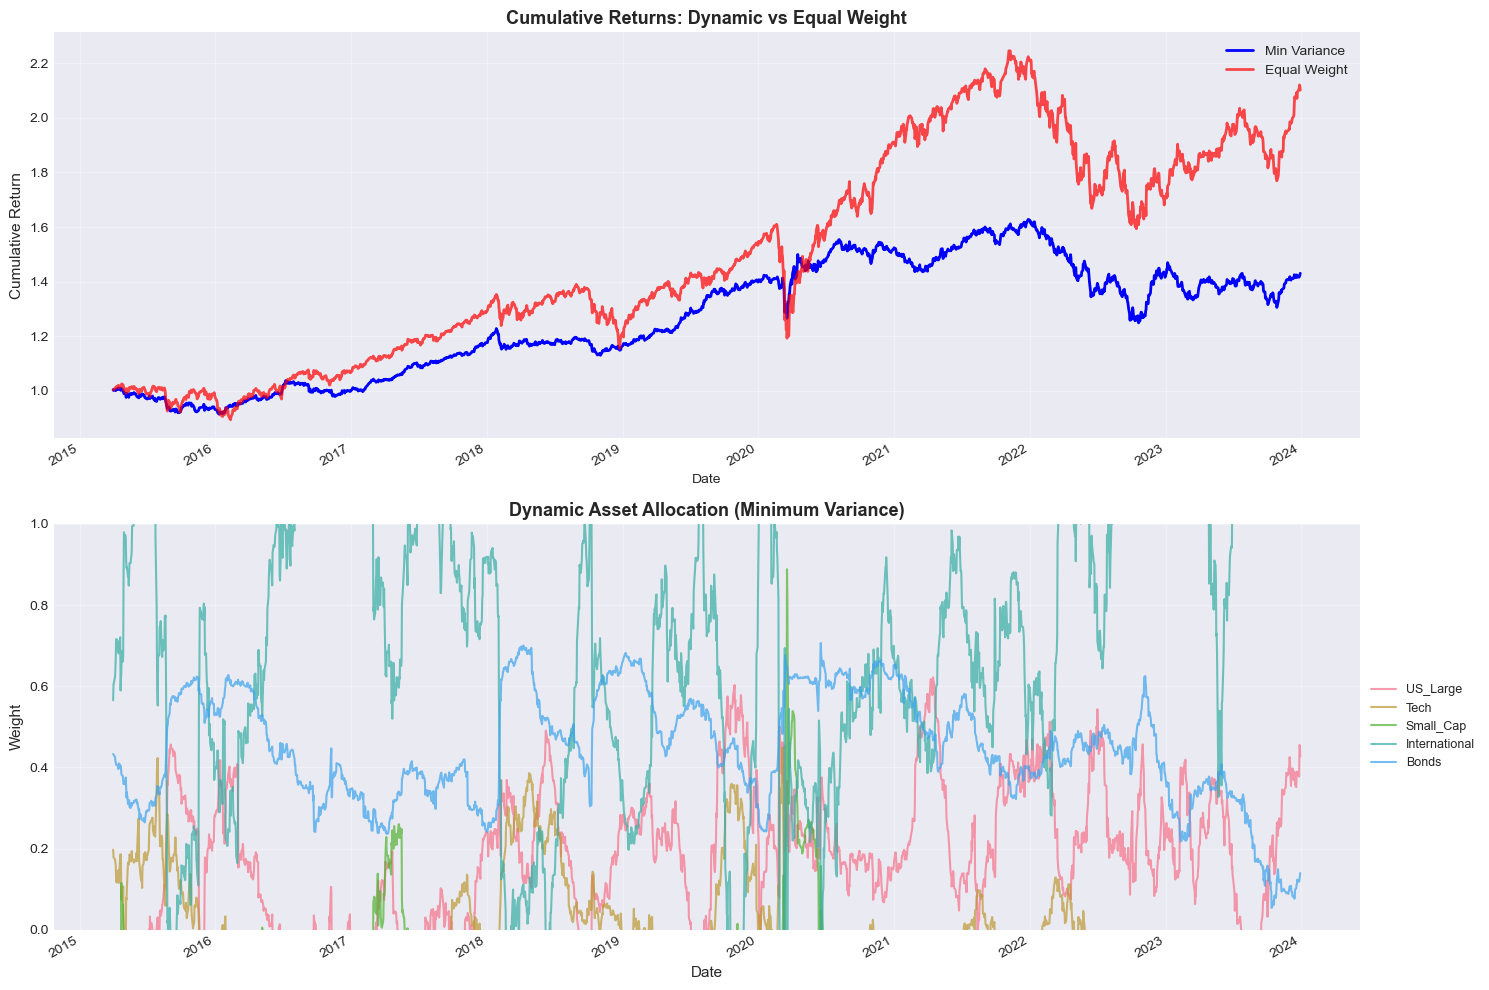


Key Insights:
• Min variance portfolio adjusts weights dynamically
• Typically lower volatility than equal weight
• May sacrifice some return for risk reduction
• Weights shift toward low-volatility assets during crises


In [31]:
# Visualize portfolio performance
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Cumulative returns
cum_dynamic = (1 + dynamic_port_returns/100).cumprod()
cum_equal = (1 + equal_port_returns/100).cumprod()

cum_dynamic.plot(ax=axes[0], linewidth=2, label='Min Variance', color='blue')
cum_equal.plot(ax=axes[0], linewidth=2, label='Equal Weight', color='red', alpha=0.7)
axes[0].set_title('Cumulative Returns: Dynamic vs Equal Weight', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Cumulative Return', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Dynamic weights over time
dynamic_weights.plot(ax=axes[1], linewidth=1.5, alpha=0.7)
axes[1].set_title('Dynamic Asset Allocation (Minimum Variance)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Weight', fontsize=11)
axes[1].set_ylim(0, 1)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• Min variance portfolio adjusts weights dynamically")
print("• Typically lower volatility than equal weight")
print("• May sacrifice some return for risk reduction")
print("• Weights shift toward low-volatility assets during crises")

## 7. Value at Risk (VaR) with GARCH

### 7.1 VaR Definition

**Value at Risk**: Maximum expected loss over time horizon at confidence level $\alpha$.

$$P(r_t \leq VaR_t^\alpha) = \alpha$$

Typical: $\alpha = 0.01$ or $0.05$, horizon = 1 day.

### 7.2 GARCH-based VaR

**Assuming Normal**:
$$VaR_t^\alpha = \mu_t + z_\alpha \sigma_t$$

where $z_\alpha$ is $\alpha$-quantile of $N(0,1)$.

**With Student-t**:
$$VaR_t^\alpha = \mu_t + t_\alpha(\nu) \sigma_t$$

where $t_\alpha(\nu)$ is quantile of $t(\nu)$.

### 7.3 Advantages

- **Time-varying**: VaR changes with volatility
- **Forward-looking**: Uses latest information
- **Captures clustering**: Higher VaR during volatile periods

### 7.4 Backtesting

**Unconditional coverage test**:
- Count violations: $V = \sum_{t=1}^T I(r_t < VaR_t^\alpha)$
- Expected: $E[V] = \alpha T$
- Test: $H_0: \frac{V}{T} = \alpha$

**Conditional coverage test** (Christoffersen):
- Test for violation clustering
- Good model: violations independent

In [35]:
# Calculate VaR using GARCH
print("\n" + "="*60)
print("Value at Risk with GARCH")
print("="*60)

# Use GARCH(1,1) with Student-t
alpha = 0.05  # 5% VaR

# Extract parameters
mu = garch_sp_fit.params['mu']
nu = garch_sp_fit.params['nu']  # degrees of freedom
cond_vol = garch_sp_fit.conditional_volatility

# Calculate VaR
t_quantile = stats.t.ppf(alpha, nu)
var_t = mu + t_quantile * cond_vol

# Also calculate with Normal for comparison
z_quantile = stats.norm.ppf(alpha)
var_normal = mu + z_quantile * cond_vol

# Backtest
violations_t = (sp_returns < var_t).astype(int)
violations_normal = (sp_returns < var_normal).astype(int)

violation_rate_t = violations_t.mean()
violation_rate_normal = violations_normal.mean()

print(f"\nVaR at {alpha:.1%} confidence level:")
print(f"  Expected violation rate: {alpha:.2%}")
print(f"  Actual (Student-t): {violation_rate_t:.2%} ({violations_t.sum()} violations)")
print(f"  Actual (Normal): {violation_rate_normal:.2%} ({violations_normal.sum()} violations)")

# Test if violation rate is significantly different from alpha
n = len(sp_returns)
p_value_t = 2 * min(stats.binom.cdf(violations_t.sum(), n, alpha),
                     1 - stats.binom.cdf(violations_t.sum() - 1, n, alpha))

print(f"\nUnconditional Coverage Test (Student-t):")
print(f"  P-value: {p_value_t:.4f}")
if p_value_t > 0.05:
    print(f"  ✓ Cannot reject correct coverage")
else:
    print(f"  ✗ Reject correct coverage")


Value at Risk with GARCH

VaR at 5.0% confidence level:
  Expected violation rate: 5.00%
  Actual (Student-t): 4.14% (250 violations)
  Actual (Normal): 5.77% (348 violations)

Unconditional Coverage Test (Student-t):
  P-value: 0.0019
  ✗ Reject correct coverage


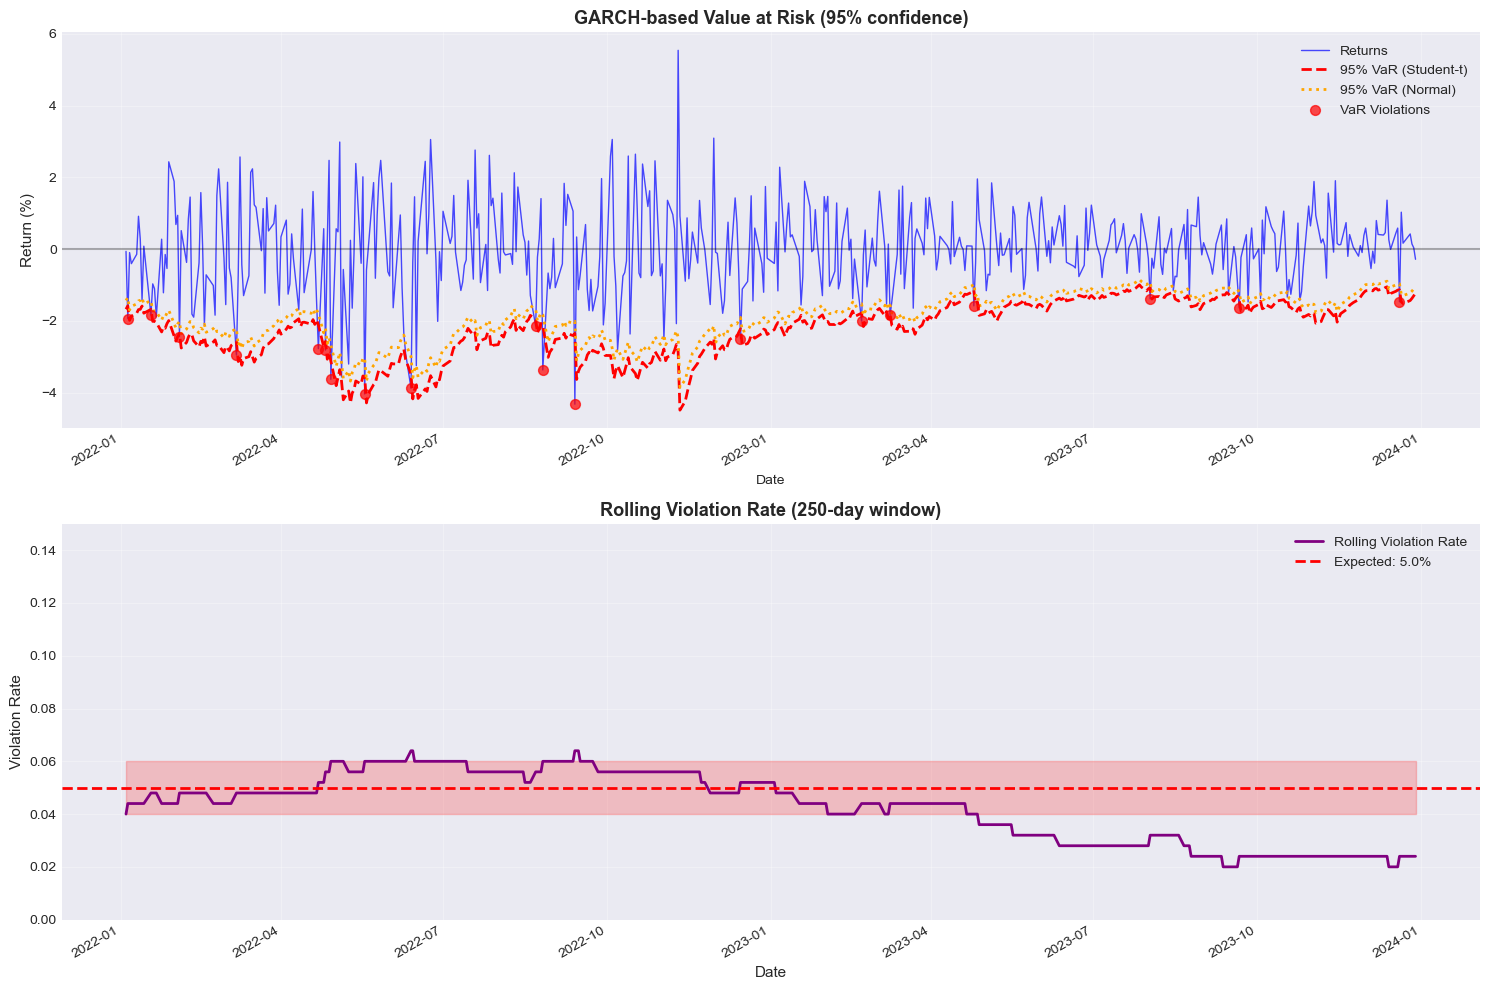


VaR Insights:
• GARCH-VaR adapts to changing volatility
• Student-t better captures tail risk than Normal
• Violations should occur at expected rate
• Clustering of violations indicates model issues


In [37]:
# Visualize VaR
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Returns with VaR bands
window_start = -500
sp_returns[window_start:].plot(ax=axes[0], linewidth=1, alpha=0.7, 
                               color='blue', label='Returns')
var_t[window_start:].plot(ax=axes[0], linewidth=2, color='red', 
                         style='--', label=f'{(1-alpha)*100:.0f}% VaR (Student-t)')
var_normal[window_start:].plot(ax=axes[0], linewidth=2, color='orange',
                              style=':', label=f'{(1-alpha)*100:.0f}% VaR (Normal)')

# Highlight violations
violation_dates_t = sp_returns[violations_t == 1].index
violation_dates_t = [d for d in violation_dates_t if d in sp_returns[window_start:].index]
if len(violation_dates_t) > 0:
    axes[0].scatter(violation_dates_t, 
                   sp_returns.loc[violation_dates_t],
                   color='red', marker='o', s=50, zorder=5,
                   label='VaR Violations', alpha=0.7)

axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title(f'GARCH-based Value at Risk ({(1-alpha)*100:.0f}% confidence)', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Rolling violation rate
rolling_window = 250  # 1 year
rolling_violations = violations_t.rolling(window=rolling_window).mean()
rolling_violations[window_start:].plot(ax=axes[1], linewidth=2, 
                                      color='purple', label='Rolling Violation Rate')
axes[1].axhline(y=alpha, color='red', linestyle='--', 
               label=f'Expected: {alpha:.1%}', linewidth=2)
axes[1].fill_between(rolling_violations.index[window_start:], 
                     alpha - 0.01, alpha + 0.01,
                     alpha=0.2, color='red')
axes[1].set_title(f'Rolling Violation Rate ({rolling_window}-day window)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Violation Rate', fontsize=11)
axes[1].set_ylim(0, 0.15)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVaR Insights:")
print("• GARCH-VaR adapts to changing volatility")
print("• Student-t better captures tail risk than Normal")
print("• Violations should occur at expected rate")
print("• Clustering of violations indicates model issues")

## 8. Summary and Best Practices

### 8.1 Advanced GARCH Workflow

**Step 1: Choose Model Complexity**
- Univariate vs Multivariate
- Consider computational constraints
- DCC for medium-size portfolios

**Step 2: Test for Long Memory**
- Examine ACF at long lags
- Consider FIGARCH if needed
- IGARCH as approximation

**Step 3: Specify Distribution**
- Student-t for fat tails
- Skewed distributions if needed
- Compare using likelihood

**Step 4: Apply to Problem**
- VaR calculation
- Portfolio optimization
- Option pricing
- Risk management

### 8.2 Model Selection Guide

| Application | Model Choice | Reason |
|-------------|--------------|--------|
| Single asset VaR | GARCH(1,1)-t | Simple, effective |
| Portfolio risk | DCC-GARCH | Time-varying correlations |
| Long-horizon | FIGARCH | Captures persistence |
| Spillover analysis | BEKK or VAR-GARCH | Cross-asset dynamics |
| High-frequency | Realized GARCH | Uses intraday data |

### 8.3 Key Takeaways

**Long Memory**:
- Volatility shocks persist very long
- IGARCH common in practice
- FIGARCH more flexible

**Multivariate GARCH**:
- DCC most practical for portfolios
- Captures time-varying correlations
- Essential for risk management

**Spillovers**:
- Volatility transmits across markets
- Correlations spike in crises
- Important for diversification

**Applications**:
- VaR: Time-varying risk measure
- Portfolio: Dynamic allocation
- GARCH-M: Risk-return trade-off

### 8.4 Limitations

- **Curse of dimensionality**: Large portfolios difficult
- **Parameter instability**: May need recursive estimation
- **Model risk**: Specification uncertainty
- **Computational cost**: Especially multivariate

### 8.5 Future Directions

- **Machine learning**: Neural network GARCH
- **High-frequency**: Realized measures
- **Regime-switching**: Markov-switching GARCH
- **Factor models**: GARCH with factors
- **Copula-GARCH**: Flexible dependence

## 9. Exercises

### Exercise 1: Long Memory Analysis
For a stock index of your choice (10+ years):
1. Calculate absolute returns
2. Compute ACF up to 500 lags
3. Create log-log plot
4. Estimate decay parameter
5. Is there evidence of long memory?

### Exercise 2: Multivariate GARCH
For 3 assets (stocks, bonds, commodities):
1. Fit univariate GARCH(1,1) to each
2. Extract standardized residuals
3. Calculate rolling correlations
4. Implement simplified DCC
5. Plot dynamic correlation matrix

### Exercise 3: Volatility Spillovers
Analyze spillovers between two markets:
1. Download data for US and European stocks
2. Calculate squared returns
3. Test Granger causality in both directions
4. Estimate rolling correlations
5. Identify crisis periods with high spillovers

### Exercise 4: Portfolio Optimization
Build dynamic portfolio strategy:
1. Use 5 assets, 5 years data
2. Estimate GARCH for each asset
3. Calculate time-varying covariance matrix
4. Construct minimum variance portfolio
5. Compare with static and equal-weight portfolios

### Exercise 5: VaR Backtesting
Comprehensive VaR analysis:
1. Estimate GARCH(1,1) with Student-t
2. Calculate 1% and 5% VaR
3. Count violations over time
4. Perform unconditional coverage test
5. Test for violation clustering
6. Calculate expected shortfall (CVaR)

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Key Papers:
1. Baillie, R.T., Bollerslev, T., & Mikkelsen, H.O. (1996). Fractionally integrated generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics*, 74(1), 3-30.
2. Engle, R. (2002). Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models. *Journal of Business & Economic Statistics*, 20(3), 339-350.
3. Engle, R.F., & Kroner, K.F. (1995). Multivariate simultaneous generalized ARCH. *Econometric Theory*, 11(1), 122-150.
4. Engle, R.F., Lilien, D.M., & Robins, R.P. (1987). Estimating time varying risk premia in the term structure: The ARCH-M model. *Econometrica*, 55(2), 391-407.
5. Christoffersen, P.F. (1998). Evaluating interval forecasts. *International Economic Review*, 39(4), 841-862.

### Textbooks:
1. Bauwens, L., Laurent, S., & Rombouts, J.V. (2006). Multivariate GARCH models: A survey. *Journal of Applied Econometrics*, 21(1), 79-109.
2. Francq, C., & Zakoïan, J.M. (2019). *GARCH Models: Structure, Statistical Inference and Financial Applications* (2nd ed.). Wiley.
3. Tsay, R.S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley. Chapters 7-8.
4. Taylor, S.J. (2008). *Modelling Financial Time Series* (2nd ed.). World Scientific.

### Software:
1. ARCH package: https://arch.readthedocs.io/
2. PyFlux: https://pyflux.readthedocs.io/
3. rmgarch (R): https://cran.r-project.org/package=rmgarch
4. rugarch (R): https://cran.r-project.org/package=rugarch

### Online Resources:
1. Kevin Sheppard's Oxford Materials: https://www.kevinsheppard.com/
2. Quantitative Risk Management Guide: https://qrm.readthedocs.io/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]